#Energy Analysis Residential Home

We are considering alternative energy supply options to lower the electricity bill and to sustain our household during power outages.  The electrical supply in South Africa is managed poorly and we experience regular scheduled power cuts, politely called "Load Scheduling".

A key input to the analysis is the quantity of solar generated electricity.  To quantify this, a relatively accurate model of the climatic conditions, the sun's position, and the characteristics of the system components are required.  The various sections in this document review the effect of the these different elements.

We live in a 240 m$^2$ free standing house in the urban residential area of Centurion, Gauteng, South Africa (25$^\circ$51$^\prime$S, 28$^\circ$10$^\prime$E).  The house currently supports three adults, two of whom are working off-site during the day.  The house has a 150 litre and a 80 litre geyser (water heater), an often used stove hob and oven, and a 1.5 kW pool pump.  The 150 litre geyser is covered with an insulating blanket and controlled by a [Geyserwise](www.geyserwise.co.za/) timer.  The 80 litre geyser is controlled only by a simple thermostat, with no timing control.  

This analysis is based on domestic energy measurements for two months only: June and July, winter months.  In winter we tend to use heaters on some cold evenings, if the wood fire is not burning. 

All analyses are done against a particular background. In this case we are reviewing the facts towards the purchase of an [IMEON 3.6](http://www.imeon-energy.com/imeon-9-12/) system - or the Victron equivalent.  The IMEON 9.12 would be really nice, but probably an overkill in our situation. Very briefly: the IMEON 3.6 has an inverter capability of 3 kW, but supplementing the power supply with a grid feed up to 6 kW. So these two are the magic numbers.

Will you find advice here on whether you should install a PV system? Probably not.  The decision to install a PV system  is a highly personal matter. It depends on your energy needs, financial position and your attitude towards the big Green Thing.  True to my post-structuralist world view, I will share with you what I learned, but your decision is up to yourself. Don't thank we and don't blame me, just review my findings and believe what you will and do as you please.



This document is still in process, and will be for many years. When complete I would like to

1. Determine a few fundamental rules of thumb to be able to speak to suppliers from an authoritative position.

1. Determine a suitable design for my needs: how large a PV panel and how large a battery bank should be used?

1. Consider the financial implication of solar energy for my house.  At the outset is was quite clear that it is not a financially viable option. The input costs are just too high.  But how big is the financial hit?



In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pyradi.ryplot as ryplot
import os.path
from scipy.optimize import curve_fit
import datetime
from dateutil.parser import parse
from collections import defaultdict
import re

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
# import pyradi.ryplanck as ryplanck
# import pyradi.ryfiles as ryfiles
# import pyradi.rymodtran as rymodtran

# import xlsxwriter

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at 150 dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('figure', figsize=(10,8))
%config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

#Energy analysis

We have an [Engage Efergy](http://efergy.com/uk/products/engage-hub-kit) monitor that samples the electricity use at one-minute intervals.  This section analyses our energy use during approximately three weeks in the (winter) month of June. During this time we used room heaters on some afternoons and evenings, but the pool pump was not running.

Read the file and form a few new columns from the existing data.  The data in the input file is given in units of Watt-minutes.

In [2]:
filenames = ['data/201506-efergy.csv','data/201507-efergy.csv']
# filenames = ['data/201507-efergy.csv']
for i,filename in enumerate(filenames):
    if i == 0:
        df = pd.read_csv(filename)
        df.columns = ['DateTime','Wm']
    else:
        dfn = pd.read_csv(filename)
        dfn.columns = ['DateTime','Wm']
        df = df.append(dfn)

#remove all (empty) lines with NaN values
df = df[df.Wm.notnull()]
#calc the energy in kWh
df['kWm'] = df['Wm'] / 1000.
df['kWh'] = df['Wm'] * 60. / 1000.
#convert from string to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])
# set index to be the date-time
df = df.set_index('DateTime')

The first graph shows the use at one-minute intervals over the whole period.  Note that at times there were quite high one-minute peaks, beyond 6 kW, almost reaching 10 kW.

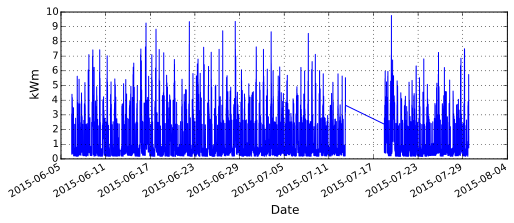

In [3]:
p = ryplot.Plotter(1,1,1, figsize=(8,3));
p.plot(1, df.index.values, df['kWm'],'','Date','kWm',xIsDate=True,xtickRotation=30);

The peaks are somewhat concerning, but not a problem if their durations are short.  The next analysis show all runs that exceed a 6 kW level.  The first graph shows the individual runs as function of time.  The second graph shows the number of occurrences versus run length.

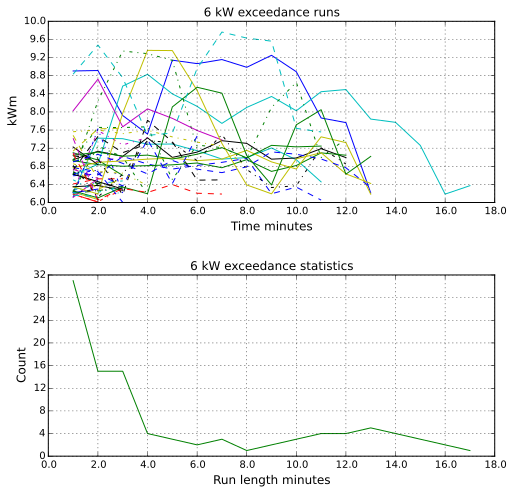

In [4]:
thr = 6
dfp = df.copy()
dfp['1'] = np.ones(dfp.kWm.shape)
#select portions exceeding the threshold
dfp['thr'] = np.where(dfp['kWm']>thr, 1, 0)
#get the individual runs that exceed the threshold
dfp['RunID'] = (dfp.thr != dfp.thr.shift()).cumsum()
#select only the runs above threshold
dfps = dfp[dfp['thr'] == 1].copy()

#accumulate run length info
rlens = defaultdict(int)
q = ryplot.Plotter(2,2,1, figsize=(8,8));
for group in df.groupby(dfps.RunID):
    dfd = group[1].copy()
    rlens[dfd.index.shape[0]] += 1
    dfd['t'] = np.cumsum(np.ones(dfd.index.shape))
    q.plot(1, dfd['t'], dfd['kWm'],'6 kW exceedance runs','Time minutes','kWm');

rlens = np.asarray([[item,rlens[item]] for item in rlens.keys()])
q.plot(2, rlens[:,0], rlens[:,1],'6 kW exceedance statistics','Run length minutes','Count');


The statistics of the 'instantaneous' power use are shown below.  Note that less than 1% of the one-minute slots exceeded 6 kW usage.  Only 15% of the time did the power use exceed 3 kW.

Note the peaks around 2.0-2.5 kW and 3.0-3.5 kW.  The second peak stems from the large geyser's 3 kW element plus the 'normal background' power use.

    Power kW  Probability
0          0     0.026305
1          1     0.685453
2          2     0.759733
3          3     0.859499
4          4     0.959771
5          5     0.982983
6          6     0.995095
7          7     0.997985
8          8     0.999413
9          9     0.999809
10        10     1.000000


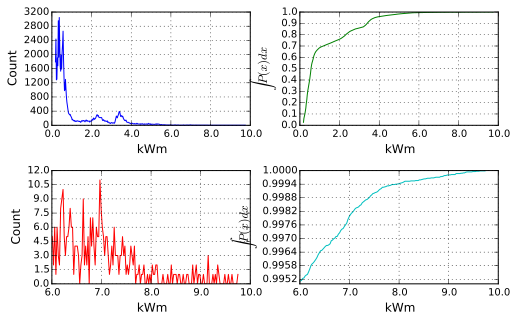

In [5]:
q = ryplot.Plotter(2,2,2, figsize=(8,5));
hst, bins = np.histogram(df['kWm'],bins=400,density=False)
binc = (bins[1:]+bins[:-1])/2
sumHist = np.cumsum(hst).astype(np.float)
select = (binc >= 6)
sumUpToSelect = np.sum(hst[binc < 6])
q.plot(1, binc, hst,'','kWm','Count', maxNX=5);
q.plot(2, binc, sumHist/sumHist[-1],'','kWm','$\int P(x)dx$', maxNX=5);
q.plot(3, binc[select], hst[select], '','kWm','Count', maxNX=5);
q.plot(4, binc[select], (sumUpToSelect + np.cumsum(hst[select]))/sumHist[-1],
       '','kWm','$\int P(x) dx$', maxNX=5);

normsumHist = sumHist/sumHist[-1]
pval = np.linspace(0.,10.,11)
prob = np.interp(pval, binc, normsumHist )
pvsp = pd.DataFrame(np.hstack((pval.reshape(-1,1), prob.reshape(-1,1))),columns=['Power kW','Probability'])
print(pvsp)   


Next we consider the run lengths vs power levels. The graph shows the number of times (y-axis) that the labelled power use setting was maintained for the times shown on the x-axis.    Note that the graph is truncated on both axes, the data continues beyond the limits shown here.  

Note that the shortest measurement time in one minute, so this graph should be interpreted as a one-minute slot where the power level did occur, even if only for a faction of a second.

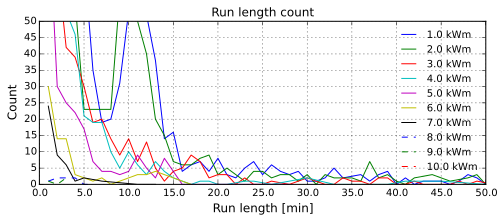

In [6]:
# https://github.com/pydata/pandas/issues/5494
# df = pd.DataFrame({"A": [1,1,2,3,2,2,3], "B": [1]*7})
# df.groupby((df.A != df.A.shift()).cumsum())["B"].sum()

dft = df.copy()
dft['1'] = np.ones(dft.kWm.shape)
thrs = np.linspace(0., 10, 11)

p = ryplot.Plotter(1,1,1, figsize=(8,3));
for thr in thrs[1:]:
    dft['thr'] = np.where(dft['kWm']>thr, 1, 0)
    # dft['Run'] = dft.groupby('thr')['1'].sum()
    # a = dft.groupby('thr')['1'].sum()

    #look for changes
    dft['Change'] = (dft.thr != dft.thr.shift())
    #count the runlength in each change
    dft['ChangeSum'] = (dft.thr != dft.thr.shift()).cumsum()
    #select only the runs above threshold
    select = (dft['thr'] == 1)
    #count the lengths of each and all runs
    rcnt = dft.ChangeSum[select].value_counts()
    #sort by length of run to get meaningful plots
    runs = rcnt.value_counts().sort_index() - 1

    p.plot(1, runs.index.values, runs.values,'Run length count','Run length [min]','Count', 
           label=['{} kWm'.format(thr)], pltaxis=[0,50, 0, 50]);


The following graph shows the energy use per day over the month.

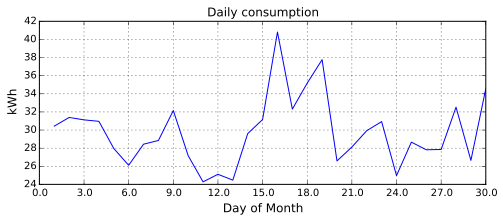

In [7]:
dailysum = df.copy()
dailysum['1'] = np.ones(dailysum.kWm.shape)
dailysum = dailysum.groupby(lambda x: (x.day)).sum() 
dailysum['kWh'] = 24 * dailysum['kWm'] / (dailysum['1'])
dailysum.drop(['Wm','kWm','1'], axis=1, inplace=True)
p = ryplot.Plotter(1,1,1, figsize=(8,3));
p.plot(1, dailysum.index.values, dailysum['kWh'],'Daily consumption','Day of Month','kWh');

If we plot the daily usage, all on the same graph, it gets quite confusing, because the usage patterns are not really well correlated.  This is largely attributable to the small geyser and room heating switching on at random times.  There are a few apparent patterns:  

-  The large geyser switching on early on the morning (on a GeyserWise timer)
-  Some peaks around 10:00 in the morning (clothes ironing, house cleaning)
-  Peaks in the afternoon/evening (cooking, room heating)

The most important observation here is that the peaks occur outside of the period of peak solar energy.  Therefore, some form of energy storage would be required to make use of solar energy.  The two obvious storage mechanisms are warming the water in the geyser and storing electrical energy in batteries.   Storing energy in warm water should alleviate the early morning peak so some extent (provided there is not a significant heat loss during the night).  The only way to store solar energy for the evening peak is in electrical batteries.

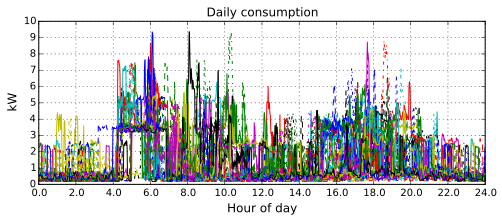

In [8]:
p = ryplot.Plotter(1,1,1, figsize=(8,3));
for group in df.groupby(df.index.day):
    dfd = group[1].copy()
    dfd['1'] = np.ones(dfd.index.shape)
    dfd['HoD'] =  dfd['1'].cumsum()/60.
    p.plot(1, dfd['HoD'], dfd['kWm'],'Daily consumption','Hour of day','kW',
          pltaxis=[0,24,0,10 ], maxNX=12);

This graph shows the average daily consumption over the full period, as function of time of day with one minute intervals.

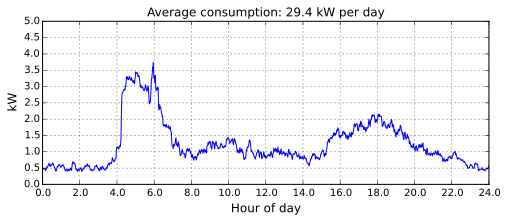

In [9]:
minmeans = df.copy()
minmeans['1'] = np.ones(minmeans.kWm.shape)

minmeans = minmeans.groupby(lambda x: (x.time())).sum()
minmeans['kW'] =  minmeans['kWm'] / (minmeans['1'])
minmeans.drop(['Wm','kWm','kWh','1'], axis=1, inplace=True)
minmeans['1'] = np.ones(minmeans.index.shape)
minmeans['HoD'] =  minmeans['1'].cumsum()/60.
totkW = minmeans['kW'].sum()/60
p = ryplot.Plotter(1,1,1, figsize=(8,3));
p.plot(1, minmeans['HoD'], minmeans['kW'],'Average consumption: {:.1f} kW per day'.format(totkW),
       'Hour of day','kW',pltaxis=[0,24,0,5 ], maxNX=12);

The consumption averaged over all days show clear trends, but aggregates out some of the consumption peaks which could be managed, if these are visible.  

The next analysis shows the consumption as a function of time of day, but for each weekday on its own.  This analysis shows clear trends on certain days.  The consumption during the days can be attributed to specific events, such as geysers house cleaning and ironing and the use of room heaters.  

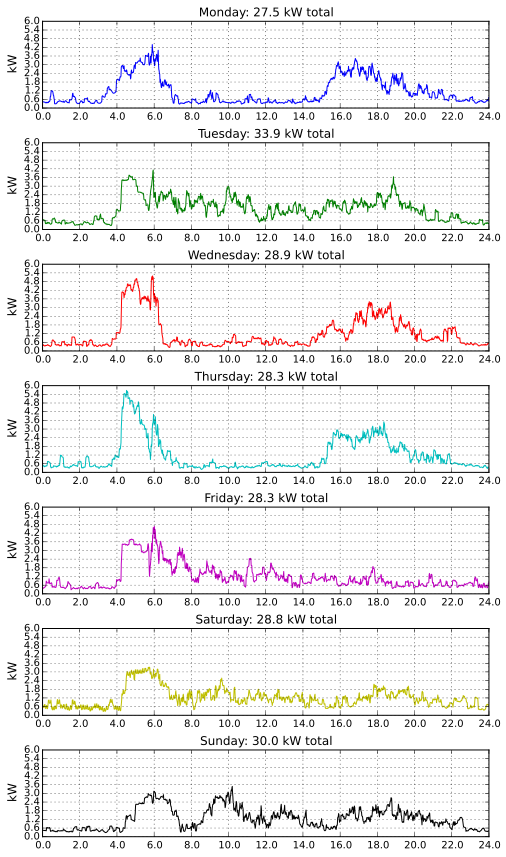

In [10]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dfd = df.copy()
dfd['Dates'] = dfd.index
dfd['week_days'] = dfd.index.weekday
x =dfd.pivot_table(index='Dates', columns='week_days', values='kWm', aggfunc='mean')

p = ryplot.Plotter(1,7,1, figsize=(8,15));
for wday in [0,1,2,3,4,5,6]:
    dfwd = x[np.isfinite(x.icol(wday))].icol(wday)
    dfwd = dfwd.groupby(lambda x: (x.time())).mean()
    
    tb = pd.DataFrame(np.ones(dfwd.index.shape))
    tb['HoD'] =  tb.icol(0).cumsum()/60.
    totkW = dfwd.sum()/60
    p.plot(wday+1, tb['HoD'], dfwd,'{}: {:.1f} kW total'.format(days[wday],totkW),'','kW',
          pltaxis=[0,24,0,6 ], maxNX=12);

If the 150 litre water geyser can be supplied from a solar geyser or from an alternative PV supply. If this load is excluded from the rest of the supply it simplifies load management a bit. The geyser timer runs at 3kW for two hours in the morning.  This load is simply subtracted from the average load - somewhat simplistic, but the answer is still a reasonably good indication of the energy use.

Secondly, we decided to bypass the heavy draining equipment such as the stove, the room heaters and tumble drier from the PV system.  The exact energy use is not known, but for the moment  2 kWh over the time period 15:00-19:00 is removed from the daily use profile.

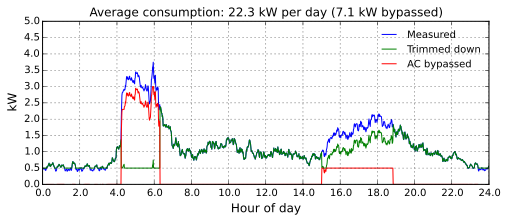

In [11]:
# removes = [[253,10,2.3], [263,115,3.0],[900,230,0.5], [420, 600, -0.75] ]
removes = [[253,10,2.3], [263,115,3.0],[900,230,0.5] ]

minmsansG = minmeans.copy()

for remove in removes:
    lo = remove[0]
    hi = lo + remove[1]
    minmsansG['kW'][lo:hi] = minmsansG['kW'][lo:hi] - remove[2]
minmsansG['kW'] = np.where(minmsansG['kW']<0.5, 0.5, minmsansG['kW'])

totkWsansG = minmsansG['kW'].sum()/60
reqAC = minmsansG['kW']
timeB = minmsansG['HoD']
removedAC = minmeans['kW'] - reqAC
totkWRemoved = removedAC.sum()/60

p = ryplot.Plotter(1,1,1, figsize=(8,3));
p.plot(1, timeB, minmeans['kW'],label=['Measured']);
p.plot(1, timeB, reqAC,'','','',pltaxis=[0,24,0,5], maxNX=12,label=['Trimmed down']);
p.plot(1, timeB, removedAC,'Average consumption: {:.1f} kW per day ({:.1f} kW bypassed)'.format(totkWsansG,totkWRemoved),
       'Hour of day','kW',pltaxis=[0,24,0,5], maxNX=12,label=['AC bypassed']);


The next analysis is a gross simplification, but attempts to find the maximum solar PV panel supply capacity and battery capacity required to make best use of the solar energy. This analysis is very much simplified in the sense that (1) the cost of equipment is not considered, (2) we model solar energy generation to be a cosine with base width of 10 hours centred around 12:00 noon and peak of 0.6 kWAC/kWPanel (of course one must consider local solar time, also the day is not 10 hours long).

The duration of the day and generation peak of 0.6 kW AC per 1 kW panel rating is motivated on the Harare results shown below.  Out location is quite far from Harare, but this is more or less relevant and the best information I have.

This time-step simulation starts at 15:00 on the assumption of a fully charged battery.  The load discharges the battery down to the depth of discharge limit, after which the grid supply is used as energy source.  The simulation run until 24:00 and then starts the next day, running until 15:00 in the next afternoon, after which the cycle is assumed to be the same.  

In [12]:
def calcProfile(tstrt, ratingPV, batvolt, batCap, batDoD, batACEff, batDCEff,
                maxInverter,maxBatCharge,reqAC,removedAC):
    """Calculate a 24-hour energy use time profile.

    Args:
        | tstrt (float): decimal time in hours when UPS operation starts
        | ratingPV (float): PV rating of the solar panels [W]
        | batvolt (float): battery voltage [V]
        | batCap (float): battery capacity [Ah]
        | batDoD (float): allowable battery depth of discharge [pu]
        | batACEff (float): AC generation efficiency from battery [pu]
        | batDCEff (float): DC battery charge efficiency [pu]
        | maxInverter (float): maximum inverter generation capability [W]
        | maxBatCharge (float): maximum battery charge current [A]
        | reqAC (np.array(float)): trimmed down required AC power temporal profile [kW]
        | removedAC (np.array(float)): trimmed required AC power temporal profile [kW]

    Returns:
        | A number of temporal profiles.

    Raises:
        | No exception is raised.
    """

    # timeB, reqAC
    genPV = ratingPV * 0.7 * np.cos( (timeB-12.0) * np.pi / 10  )
    genPV = np.where(genPV<0, 0 , genPV)

    bat2ACi = batCap * batACEff * (1-batDoD) * 60. # Wm available as AC energy
    batchmax = maxBatCharge * batvolt # battery charge at maxBatCharge A max

    for i in [0,1]:
        # do this twice, first time to obtain battery state for second time actual
        tcyc = tstrt 
        bat2AC = bat2ACi if i==0 else engBatt[(tcyc-1)%1440]
        engBatt = np.zeros((24 * 60, 1))
        engGrd = np.zeros((24 * 60, 1))
        engLst = np.zeros((24 * 60, 1))
        engBatt[tcyc%1440] = bat2AC
        battOn = False

        for tsim in np.linspace(0,24,1440):

            # if there is solar power, charge the battery first, then supply house
            PVavail = genPV[tcyc%1440]
            battState = engBatt[tcyc%1440][0]
            if PVavail <= 0:  #  solar power available
                PVused = 0
            else:
                if battState < bat2AC:  # battery not yet fully charged,
                    # calculate the available charge
                    PVcharge = batchmax if PVavail >=batchmax else PVavail
                    #then charge by that much
                    battState += PVcharge * batDCEff
                    # this energy is left for use in the house
                    PVavail -= PVcharge

                #use excess PV power to supply the house load
                PVused = PVavail if reqAC[tcyc%1440] * 1000. > PVavail else reqAC[tcyc%1440] * 1000.
                #this is not used to charge battery or used in house
                PVavail -= PVused
                #this much PV energy was not used for charging or load
                engLst[tcyc%1440] = PVavail

            if tcyc%1440 >= tstrt and battState > 0.:
                battOn = True  #switch on the UPS

            if battOn:
                inverterAC = maxInverter if reqAC[tcyc%1440] * 1000. > maxInverter else reqAC[tcyc%1440] * 1000.
                battUsed = inverterAC if battState >= inverterAC else battState
                battState -= battUsed
            else:
                battUsed = 0.


            if battState <= 0.:
                battOn = False

            engBatt[(tcyc+1)%1440] = battState 

            #energy pulled from the grid
            engGrd[(tcyc)%1440] = reqAC[tcyc%1440] * 1000. - battUsed - PVused

            tcyc += 1
            
    #now prepare return values
    return genPV, engLst, reqAC, removedAC, engGrd, bat2ACi, batchmax, engBatt


Batteries require 3456 Wh from PV panels to charge
Batteries charge at 720 W (15.0 A) maximum
Required energy including pypass 29.4 kWh 
Required energy excluding bypass 22.3 kWh 
PV energy generated 8.9 kWh 
PV energy lost 0.5 kWh 
Grid feed including bypass 21.4 kWh 
Grid feed excluding bypass 14.3 kWh 


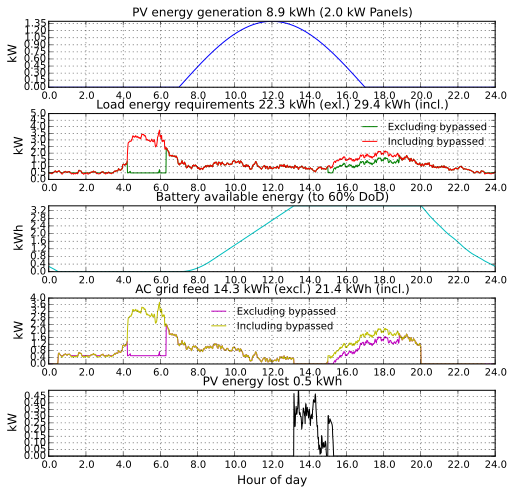

In [16]:
tstrt = 20.00 * 60  # time in minutes at which the battery inverter is switched on
ratingPV = 2000.  # W installed panel capacity
batvolt = 48 # nominal battery voltage
batCap = 200. * batvolt  # Wh  battery capacity in Ah * voltage
batDoD = 0.6 # depth of dischage
batACEff = 0.9 # battery discharge efficiency only this much is available as AC power
batDCEff = 0.9 # battery charge efficiency only this much is available as charge
maxInverter = 3000  # W maximum that the inverter can supply
maxBatCharge = 15 # maximum battery chage voltage

genPV, engLst, reqAC, removedAC, engGrd, bat2ACi, batchmax, engBatt = calcProfile(
    tstrt, ratingPV, batvolt, batCap, batDoD, batACEff, batDCEff,
            maxInverter,maxBatCharge,reqAC,removedAC)

factor = 1000. * 60.
PVEnergyGen = genPV.sum()/factor
PVEnergyLost = engLst.sum()/factor
gridReqTotal = reqAC.reshape(-1,1)+removedAC.reshape(-1,1)
gridReqIncl = gridReqTotal.sum()/60
gridReqExcl = 1000. * reqAC.sum()/factor
gridInTotal = engGrd/1000.+removedAC.reshape(-1,1)
gridInIncl = 1000*(gridInTotal).sum()/factor
gridInExcl = engGrd.sum()/factor

print('Batteries require {:.0f} Wh from PV panels to charge'.format(bat2ACi/60.))
print('Batteries charge at {:.0f} W ({} A) maximum'.format(batchmax,batchmax/48.))
print('Required energy including pypass {:.1f} kWh '.format(gridReqIncl))
print('Required energy excluding bypass {:.1f} kWh '.format(gridReqExcl))
print('PV energy generated {:.1f} kWh '.format(PVEnergyGen))
print('PV energy lost {:.1f} kWh '.format(PVEnergyLost))
print('Grid feed including bypass {:.1f} kWh '.format(gridInIncl))
print('Grid feed excluding bypass {:.1f} kWh '.format(gridInExcl))
# print(PVEnergyGen - PVEnergyLost + gridInExcl )   

p = ryplot.Plotter(1,5,1, figsize=(8,8));
title = 'PV energy generation {:.1f} kWh ({} kW Panels)'.format(PVEnergyGen, ratingPV/1000.)
p.plot(1, timeB, genPV/1000.,title,'','kW',pltaxis=[0,24,0,np.max(genPV/1000.) ], maxNX=12); 
title = 'Load energy requirements {:.1f} kWh (exl.) {:.1f} kWh (incl.)'.format(gridReqExcl, gridReqIncl)
p.plot(2, timeB, reqAC, '','','',label=['Excluding bypassed'], pltaxis=[0,24,0,5], maxNX=12); 
p.plot(2, timeB, gridReqTotal, title,'','kW',label=['Including bypassed'],pltaxis=[0,24,0,5], maxNX=12); 
p.plot(3, timeB, engBatt/(60. * 1000.),'Battery available energy (to {:.0f}% DoD)'.format(100*batDoD),'','kWh',
       pltaxis=[0,24,0,bat2ACi/(60*1000.) ], maxNX=12);  
title = 'AC grid feed {:.1f} kWh (excl.) {:.1f} kWh (incl.)'.format(gridInExcl, gridInIncl)
p.plot(4, timeB, engGrd/1000.,'','','kW',label=['Excluding bypassed'])#,pltaxis=[0,24,-3,3 ], maxNX=12);  
p.plot(4, timeB, gridInTotal,title,'','kW',label=['Including bypassed'],
       pltaxis=[0,24,0,4 ], maxNX=12);  
title = 'PV energy lost {:.1f} kWh'.format(engLst.sum()/factor)
p.plot(5, timeB, engLst/1000.,title,'Hour of day','kW',pltaxis=[0,24,0,np.max(engLst/1000.) ], maxNX=12);  

In conclusion, note the following observations.  When reviewing these observation note that our target is to review a PV system with 3 kW battery inverter and a 6 kW peak demand capability.

1. There is a 'background' 24/7 consumption of around 500 W.  This includes items such as computers, lights, alarm, garden fountain, two fridges and two freezers, a satellite TV system, etc.  The energy consumption here is already 12 KWh.

1. To the 'background' power must be added all intermittent use devices such as blow hair driers, kitchen devices, hand tools, the stove hob and oven, the geyser and room heating in winter.

1.  Our energy consumption is well within the 3 kW margin for 85% of the time. A 2 kW or smaller system would require too many adaptations and inconveniences. At a 3 kW rating we are already constrained to only one device in the kitchen at the time.

2. The measurements indicate power use higher than 6 kW.  We would have to find the means to limit the peak demand, or alternatively put these high demand devices directly on the grid, not passing through the inverter.  The items to be considered here include the heat generating devices such as geysers, stove hob and oven, the tumble drier and room heaters.

3. Our maximum daily energy use can be as high as 50 kWh per day. To become totally independent of the grid would require 12-15 kW PV panels and the larger IMEON 9.12. This is too large a system for our needs. Grid-independence is not very high on our priorities.




#Solar Irradiance and Climatic Data

A 'typical meteorological year' (TMY) is a collation of selected weather data for a specific location, generated from a data bank much longer than a year in duration. It is specially selected so that it presents the range of weather phenomena for the location in question, while still giving annual averages that are consistent with the long-term averages for the location in question. The TMYs are data sets of hourly values of solar radiation and meteorological elements for a 1-year period.  <http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/>. The TMY data are available in three formats, the most recent and comprehensive being the [TMY3](http://www.nrel.gov/docs/fy08osti/43156.pdf) dataset. TMY3 data comprises long tables with these column headings: Month, Day, Hour, Beam Irradiance (W/m^2), Diffuse Irradiance (W/m^2), Ambient Temperature (C), Wind Speed (m/s), Plane of Array Irradiance (W/m^2), Cell Temperature (C), DC Array Output (W), and AC System Output (W).

TMY data  for South Africa is available [commercially](http://geosun.co.za/satellite-derived-data/) but the cost did not warrant the purchase for my need.  Limited climatic data for 14 sites in South Africa and surrounding countries, are available at no cost, thanks to the [Sauran initiative](http://sauran.net/Page/About).


#PVWatts

The [NREL PVWatts](http://pvwatts.nrel.gov/pvwatts.php) provides a very useful estimate of solar PV electricity generation.  The  [PVWatts model](http://www.nrel.gov/docs/fy14osti/60272.pdf) uses TMY3 data together with a reasonably comprehensive model to predict the PV system performance.

In the Harare analyses below the following system parameters were used as input to PVWatts:
    
|Parameter|Value|
|-|-|
|DC System Size (kW)|3|
|Module Type|Standard|
|Array Type|Fixed (open rack)|
|Array Tilt (deg)|20 / 30 / 50|
|Array Azimuth (deg)|0 (North)|
|System Losses|14%|
|Invert Efficiency|96%|
|DC to AC Size Ratio|1.1|



#Harare, Zimbabwe Data

A search for TMY3 data revealed no Pretoria data, but proposed that the Harare ((17$^\circ$51$^\prime$S, 31$^\circ$02$^\prime$E)) data could be relevant.  The [Harare climate](https://weatherspark.com/averages/29149/Harare-Mashonaland-East-Zimbabwe) climate and altitude are quite similar to the [Pretoria climate](https://weatherspark.com/averages/29023/Lanseria-Gauteng-South-Africa) in terms of temperature and seasonal rain patterns (dry winters and rainy summers).  The only significant difference is distance from the Equator: 17$^\circ$S for Harare and 25$^\circ$S for Pretoria.  This means that the day/night duration variation between the two sites is somewhat different.

In [ ]:
def toint(instr):
    return int(instr)

def tofloat(instr):
    return float(instr)

PVkW = 3.0

dicConvert = {0:toint, 1:toint, 2:toint, 3:toint, 4:toint, 5:tofloat, 6:tofloat, 7:tofloat, 8:tofloat, 9:tofloat, 10:tofloat}
dicMonths = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

The PVWatts simulator was used to calculate the predicted performance for three panel elevation/title angles: 20, 30 and 50 degrees.  The 50-degree data are not shown here because the output is considerably lower than at smaller angles.

In [ ]:
p = ryplot.Plotter(1,2,2, figsize=(8,8));
effH = []
har = {}
for i,angle in enumerate([20, 30]):
    har = pd.read_csv('data/20150615-{:2d}-deg-pvwatts_hourly.csv'.format(angle), skiprows=18, converters=dicConvert, comment='#')
    har.columns = ['Month','Day','Hour','BeamIrrad','DiffIrrad','AmbTemperature','WindSpeed','PlaneIrrad',
                        'CellTemperature','DCOutput','ACOutput']
    
    for month in range(1,13):

        harmon = har[har.Month==month].copy()
        dayMon = harmon.shape[0]/24.
        hard = harmon.groupby('Hour').mean()

        effH.append(hard['ACOutput'].sum()/(PVkW * 24. * dayMon))

        p.plot(i*2+1, hard.index.values, hard['PlaneIrrad'],'',
               'Hour of day','Plane Irradiance (W/m$^2$)',label=['{}: {:.2f} h'.format(dicMonths[month],effH[-1])],
               pltaxis=[0,24,0,1500 ], maxNX=6);  
        p.plot(i*2+2, hard.index.values, hard['ACOutput'],'',
               'Hour of day','kW/h',label=['{}: {:.2f} h'.format(dicMonths[month],effH[-1])],
               pltaxis=[0,24,0,3000 ], maxNX=6);  

        
        currentP = p.getSubPlot(i*2+1);
        currentP.set_title('Irradiance @ {}$^\circ$ tilt'.format(angle));
        currentP = p.getSubPlot(i*2+2);
        currentP.set_title('Output @ {}$^\circ$ / mean hours {:.2f} h'.format(angle, np.asarray(effH).mean()));

    #calculate the ratio of ouput power to input irradiance
    harnz = har[har['PlaneIrrad']!=0].copy()
    etop = (harnz['ACOutput'] / harnz['PlaneIrrad']).mean()
    print('AC Output power divided by plan irradiance is {:.2f} kW/(W/m2))'.format(etop))

In the analysis above we plot the irradiance and DC power output for all the months of the year.  It was quite surprising to observe that the winter output and summer outputs are not significantly different. In fact, during summer months the (average) output is lower than in winter, despite the longer days. The explanation is simple: during summer months the longer day is offset against increased cloud cover.  During winter months the days are shorter but the skies are clear.  This means that the panels need not be tilted for optimal production in winter months, they should be tilted for optimal production in summer!  This observation of course only only applies to the site considered here, with summer rainfall conditions.

The analysis also include an effective production time calculation, normalised against the solar panels PV rating.  The total energy (kWh) production was divided by the PC rating (3 kW) leading to the effective production time.  The idea is that if we multiply the panel PV rating by the effective production time, we can find the total energy produced by the panels.  The interesting observation here is that the effective production time does not differ much between summer and winter.  The value is around 6.1 hours for the Harare installation.  We will review this effective production time later for other sites as well.

The final observation here is that the power production is a factor 2.1 times the irradiance. Note that this number includes are area of the panel and all losses in the system.


#Pretoria Sauran Data

The [Sauran data for Pretoria](http://sauran.net/ShowStation.aspx?station=5) currently runs over a two-year period.  This is relatively short compared to the TMY3 data, but still significantly better than no data!  The Pretoria climate is summarised [here](https://weatherspark.com/averages/29023/Lanseria-Gauteng-South-Africa).


The Sauran data is not in TMY3 format and we will not be doing a full PVWatt analysis on this data. Instead, we will plot the data and compare to the Harare data.  The Sauran data of relevance here include:
GHI: Global horizontal irradiance [W/m^2],
DNI: Direct normal irradiance [W/m^2],
DHI: Diffuse horizontal irradiance [W/m^2], and
Air_Temp: Air temperature [degC].

The DNI applies to a panel fully directed towards the sun. To determine the irradiance on the fixed panel the angle between the sun and the panel normal must be determined.

After some analysis there appears to be strange behaviour in the data.  Further processing is postponed till later.


In [ ]:
# def todatelements(instr):
#     return re.split("\W+", instr)

# dicConvert = {1:toint,2:tofloat,3:tofloat,4:tofloat,5:tofloat,6:tofloat,7:tofloat,8:tofloat,9:tofloat,10:tofloat,11:tofloat}
# sar = pd.read_csv('data/20041023_UPR_H.dat', skiprows=3, converters=dicConvert, comment='#')
# sar.columns = ['Date','RecNum','GHI_CMP11','DNI_CHP1','DHI_CMP11','Air_Temp','BP','RH','Rain_Tot','WS','WD','WD_SD']
# #add DNI to DHI to get total irradiance
# sar['TotalIrrad'] = sar['DNI_CHP1'] + sar['DHI_CMP11']
# #split date time string into individual numbers
# sar['Year'], sar['Month'], sar['Day'], sar['Hour'], sar['Minute'] = zip(*sar['Date'].map(todatelements))
# sar.drop(['Minute', 'Date', 'RecNum','BP','RH','Rain_Tot','WS','WD','WD_SD'],axis=1, inplace=True)
# #get the mean over years, retain month, day, hour
# sar = sar.groupby([sar.Month, sar.Day, sar.Hour, ]).mean() 


#Bush Power Installation

[Bush Power](http://www.bushpower.co.za/) has a 6.6 kW solar system running in Midrand, about 20 km from Pretoria. They are  making the performance data publicly available on the [Sunny Portal](https://www.sunnyportal.com/Templates/PublicPageOverview.aspx?plant=5e54271d-c1a0-451a-a36d-f7be800aac80&splang=en-US).  The Bush Power installation has been in operation since the beginning of 2015.  The data from the Sunny portal was captured manually on order-of-magnitude.

From the [picture](http://www.bushpower.co.za/) is evident that the solar panels were mounted for convenience on the roof of an existing building. The orientation of this building is not known, and it may be concluded that the panels are not oriented very effectively.  This is evident in the low effective production time shown below.

In [ ]:
bpd = {1: 30.65, 2:33.9, 3:30.2, 4:26, 5:23.87, 6:22.67, 7:23 }
bpd = pd.DataFrame(np.asarray([[item,bpd[item]] for item in bpd.keys()]),columns=['Month','DailykWh'])
bpd['Efftime'] = bpd['DailykWh']  / 6.6
print(bpd)


#More to come later

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [ ]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi